In [ ]:
import pandas as pd
from datetime import timedelta, datetime
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import pytz # time zone
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")
#Stat models
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA


In [ ]:
url1= "https://open.africa/dataset/565b411c-1bfc-4ba8-a3d1-2b27a13f4d89/resource/764a9274-3057-4e67-adc5-60bf2b5d40a6/download/february_2018_sensor_data_archive.csv"
url2="https://open.africa/dataset/565b411c-1bfc-4ba8-a3d1-2b27a13f4d89/resource/7133202b-2f4f-46e9-b5a1-3e9b8f1bc994/download/march_2018_sensor_data_archive.csv"
url3="https://open.africa/dataset/565b411c-1bfc-4ba8-a3d1-2b27a13f4d89/resource/37bcc163-6b4f-4c7c-be06-bc0ae87cab24/download/april_2018_sensor_data_archive.csv"
url4="https://open.africa/dataset/565b411c-1bfc-4ba8-a3d1-2b27a13f4d89/resource/b5a11f77-8e35-48d0-ad5c-5d8014c46b56/download/may_2018_sensor_data_archive.csv"

In [ ]:
def wrangle(filepath):
    # Read CSV file
    df = pd.read_csv(filepath, sep=";")
    df.set_index("timestamp", inplace=True)
    df.index= pd.to_datetime(df.index)
    #choose reading for P2
    df=df[df["value_type"]== "P2"]
    #remove outliers
    df= df[df["value"]<500]
    # since this is Uganda, we shall follow 'Africa/Nairobi' time zone
    df.index= df.index.tz_convert("Africa/Nairobi")
    return df

In [ ]:
frame1 = wrangle(url1)
frame2 = wrangle(url2)
frame3=wrangle(url3)
frame4 = wrangle(url4)
frame4.head()

,sensor_id,sensor_type,location,lat,lon,value_type,value
timestamp,,,,,,,
2018-05-02 07:44:33.982172+03:00,42,SDS011,19,0.323,32.576,P2,3.30
2018-05-02 08:06:50.144415+03:00,42,SDS011,19,0.323,32.576,P2,2.60
2018-05-02 08:26:41.163608+03:00,42,SDS011,19,0.323,32.576,P2,3.13
2018-05-02 08:31:39.843516+03:00,42,SDS011,19,0.323,32.576,P2,3.30
2018-05-02 08:34:12.475604+03:00,42,SDS011,19,0.323,32.576,P2,4.10


In [ ]:
data = pd.concat([frame1,frame2, frame3, frame4], ignore_index=False)
data.head()

,sensor_id,sensor_type,location,lat,lon,value_type,value
timestamp,,,,,,,
2018-02-21 10:24:27.103718+03:00,42,SDS011,19,0.323,32.576,P2,22.10
2018-02-21 10:26:59.211947+03:00,42,SDS011,19,0.323,32.576,P2,20.40
2018-02-21 10:29:31.816092+03:00,42,SDS011,19,0.323,32.576,P2,14.00
2018-02-21 10:32:04.426529+03:00,42,SDS011,19,0.323,32.576,P2,13.40
2018-02-21 10:34:35.389060+03:00,42,SDS011,19,0.323,32.576,P2,12.73


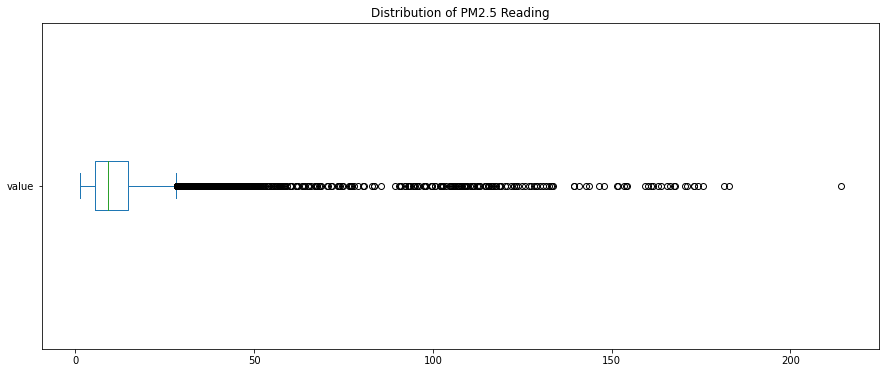

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
data["value"].plot(ax=ax, kind="box", vert=False, title="Distribution of PM2.5 Reading")

In [ ]:
data["value"].describe()

count    15801.000000
mean        12.176220
std         13.409718
min          1.170000
25%          5.470000
50%          9.100000
75%         14.600000
max        214.070000
Name: value, dtype: float64

In [ ]:
#low, high= data_f["value"].quantile([0.1,0.9])
#mask_pmread=data_f["value"].between (low,high)
#data_f=data_f[mask_pmread]

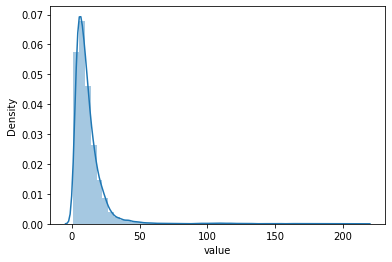

In [ ]:
#fig, ax = plt.subplots(figsize=(15, 6))
sns.distplot(data["value"]);

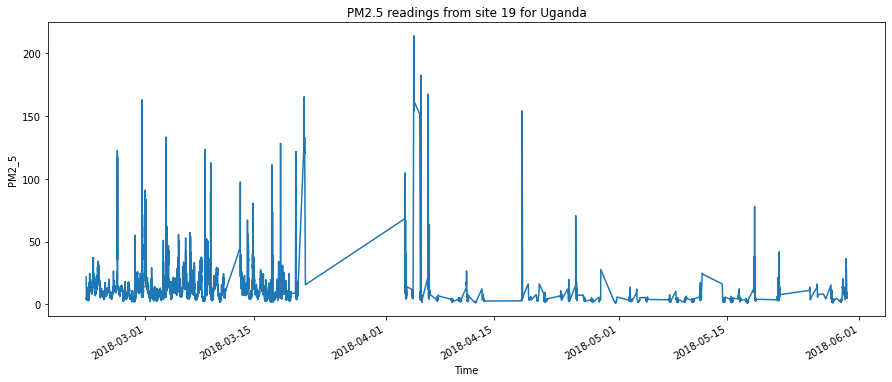

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
data["value"].plot(ax=ax,
             xlabel="Time",
             ylabel="PM2_5",
              title="PM2.5 readings from site 19 for Uganda"
             );

In [ ]:
#display(frame1, frame2, frame3, frame4)

Rolling average

In [ ]:
#resample to average per hour and establish the missing values
data[["value"]].resample("1H").mean().isnull().sum()

value    1431
dtype: int64

In [ ]:
data_f= data[["value" ]]
# resample and fill in the missing values through foward filling
data_f= data_f[["value"]].resample("1H").mean().fillna(method="ffill")
data_f["P2.L1"]=data_f["value"].shift(1)
data_f.dropna(inplace=True)
data_f.head()

,value,P2.L1
timestamp,,
2018-02-21 11:00:00+03:00,4.430435,12.221429
2018-02-21 12:00:00+03:00,5.575417,4.430435
2018-02-21 13:00:00+03:00,4.508261,5.575417
2018-02-21 14:00:00+03:00,4.985000,4.508261
2018-02-21 15:00:00+03:00,4.613913,4.985000


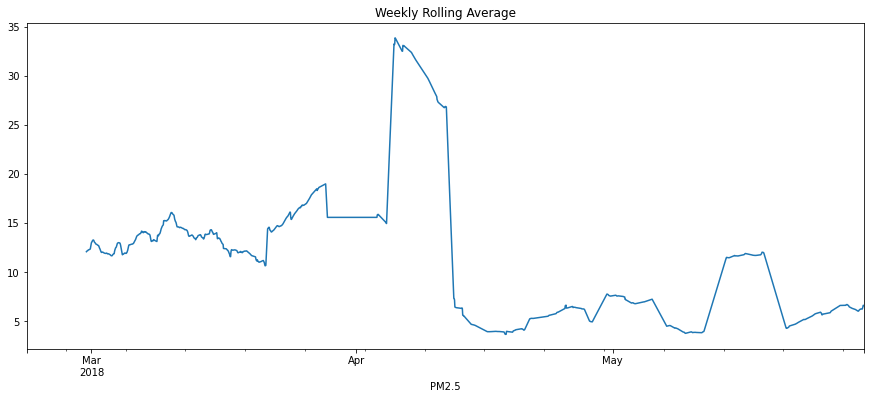

In [ ]:
# rolling average plot
fig, ax = plt.subplots(figsize=(15, 6))
data_f["value"].rolling(168).mean().plot(ax=ax, xlabel="PM2.5", title="Weekly Rolling Average");

In [ ]:
data_f.corr()

,value,P2.L1
value,1.000000,0.874437
P2.L1,0.874437,1.000000


Text(0.5, 1.0, 'PM2.5 Autocorrelation')

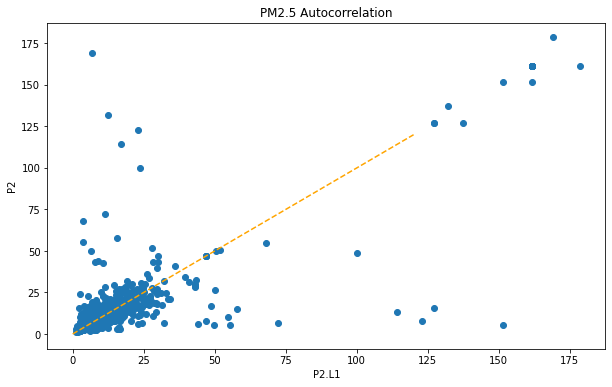

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(x=data_f["P2.L1"], y=data_f["value"])
ax.plot([0,120],[0,120], linestyle="--",color="orange")
plt.xlabel("P2.L1")
plt.ylabel("P2")
plt.title("PM2.5 Autocorrelation")

# Modelling through Linear Regression

Split

In [ ]:
target = "value"
y = data_f[target]
X = data_f.drop(columns=target)

In [ ]:
#Divide data into traing and testing set
cutoff = int(len(X)*0.8)

X_train, y_train = X.iloc[:cutoff], y.iloc[:cutoff]
X_test, y_test = X.iloc[cutoff:], y.iloc[cutoff:]

In [ ]:
# baseline model
y_mean= y_train.mean()
y_pred_baseline= [y_mean]*len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print("Mean P2 Reading:", round(y_train.mean(), 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean P2 Reading: 11.97
Baseline MAE: 8.2


In [ ]:
# model iteration
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

The model predicts better on the test data than on the training data

In [ ]:
#model evaluation
training_mae = mean_absolute_error(y_train, model.predict(X_train)) # for insample
test_mae = mean_absolute_error(y_test, model.predict(X_test)) # for out of sample
print("Training MAE:", round(training_mae, 2))
print("Test MAE:", round(test_mae, 2))

Training MAE: 2.71
Test MAE: 1.43


# Communicating results

In [ ]:
intercept = model.intercept_.round(2)
coefficient = model.coef_.round(2)

print(f"P2 = {intercept} + ({coefficient} * P2.L1)")

P2 = 1.54 + ([0.87] * P2.L1)


In [ ]:
#creating dataframe to show 
df_pred_test = pd.DataFrame(
    {
        "y_test":y_test,
        "y_pred":model.predict(X_test)
    }
)
df_pred_test.head()

,y_test,y_pred
timestamp,,
2018-05-10 20:00:00+03:00,4.115,5.124833
2018-05-10 21:00:00+03:00,4.115,5.124833
2018-05-10 22:00:00+03:00,4.115,5.124833
2018-05-10 23:00:00+03:00,4.115,5.124833
2018-05-11 00:00:00+03:00,4.115,5.124833


In [ ]:
fig = px.line(df_pred_test, labels={"values":"P2"})
fig.show();

## Auto_Regression Modelling

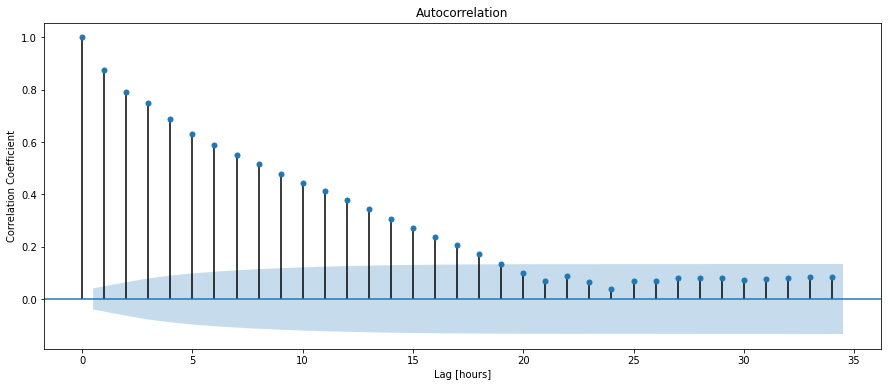

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(data_f["value"], ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");

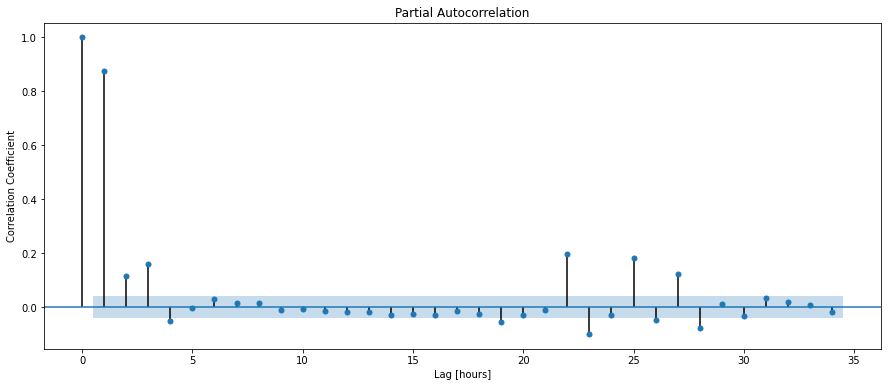

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_pacf(data_f["value"], ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");

In [ ]:
#split the data
cutoff_test = int(len(data_f["value"])*0.95)

y_train = data_f["value"].iloc[:cutoff_test]
y_test = data_f["value"].iloc[cutoff_test:]
# the x value


In [ ]:
len(y_train)+len(y_test)==len(data_f["value"])

True

build model

In [ ]:
y_train_mean = y_train.mean()
y_pred_baseline = [y_train_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print("Mean P2 Reading:", round(y_train_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))


Mean P2 Reading: 11.45
Baseline MAE: 7.97


In [ ]:
#fit the model
model = AutoReg(y_train, lags=26).fit()

In [ ]:
model.predict().isnull().sum()

26

In [ ]:
#model evaluation
y_pred = model.predict().dropna()
training_mae = mean_absolute_error(y_train.iloc[26:], y_pred)
print("Training MAE:", training_mae)

Training MAE: 2.6753826004727577


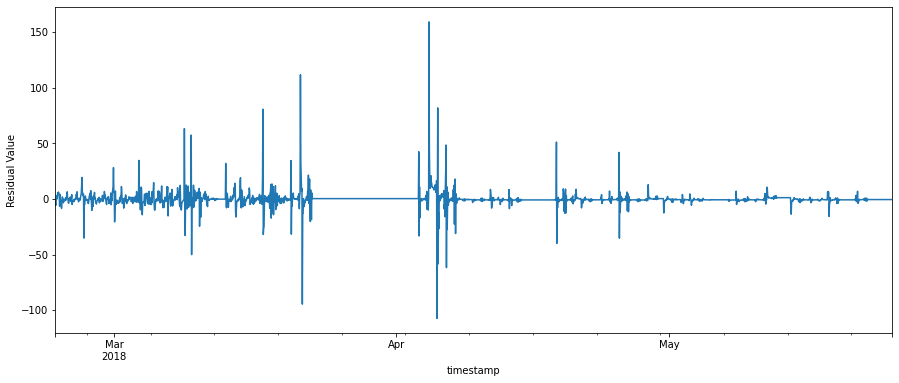

In [ ]:
y_train_resid =model.resid # stat models
fig, ax = plt.subplots(figsize=(15, 6))
y_train_resid.plot(ylabel="Residual Value", ax=ax); # timeseries plot

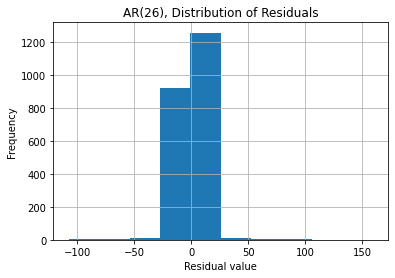

In [ ]:
# histogram of residuals
y_train_resid.hist()
plt.xlabel("Residual value")
plt.ylabel("Frequency")
plt.title("AR(26), Distribution of Residuals");

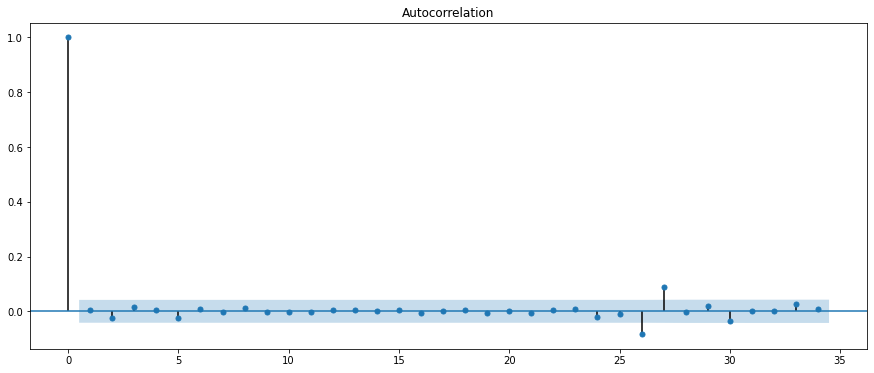

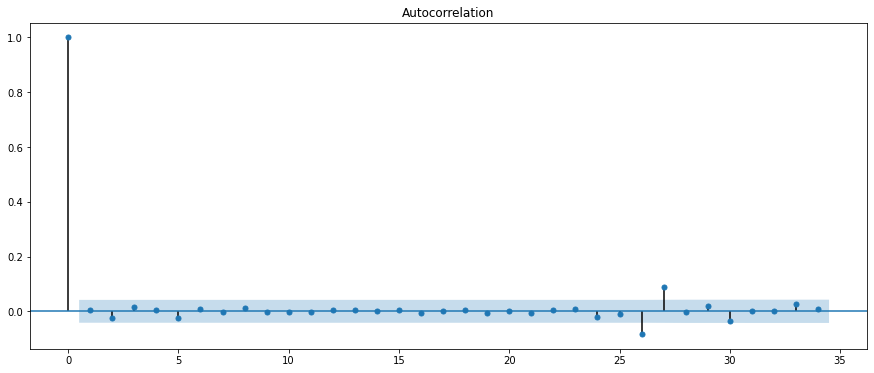

In [ ]:
# autocorrelation of the residuals
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y_train_resid, ax=ax)

There is no signal left in the residuals which we can use to predict

In [ ]:
#out of sample prediction evaluation, can our model generalise
y_pred_test = model.predict(y_test.index.min(),y_test.index.max())
test_mae = mean_absolute_error(y_test, y_pred_test)
print("Test MAE:", test_mae)

Test MAE: 5.548844360404642


In [ ]:
df_pred_test = pd.DataFrame(
    {"y_test": y_test, "y_pred": y_pred_test}, index=y_test.index
)
df_pred_test.head()


,y_test,y_pred
timestamp,,
2018-05-25 13:00:00+03:00,6.715,7.158529
2018-05-25 14:00:00+03:00,11.130,7.507310
2018-05-25 15:00:00+03:00,9.625,7.780765
2018-05-25 16:00:00+03:00,4.152,8.059237
2018-05-25 17:00:00+03:00,5.085,8.318020


In [ ]:
fig = px.line(df_pred_test, labels={"value": "P2"})
fig.show()

Traditional MAE does not work with timeseries data. thus there is need for walk foward validation

In [ ]:
# Expanding window validation

In [ ]:
%%capture

y_pred_wfv =pd.Series()
history = y_train.copy()
for i in range(len(y_test)):
    model=AutoReg(history, lags=26).fit()
    next_pred=model.forecast()
    y_pred_wfv=y_pred_wfv.append(next_pred)
    history= history.append(y_test[next_pred.index])

In [ ]:
len(y_pred_wfv)

118

In [ ]:
model=AutoReg(history, lags=26).fit()
model.forecast()

2018-05-30 11:00:00+03:00    8.141707
Freq: H, dtype: float64

In [ ]:
test_mae = mean_absolute_error(y_test, y_pred_wfv)
print("Test MAE (walk forward validation):", round(test_mae, 2))

Test MAE (walk forward validation): 1.7


In [ ]:
print(model.params)

intercept    1.054861
value.L1     0.788898
value.L2    -0.005929
value.L3     0.143259
value.L4    -0.022004
value.L5    -0.038742
value.L6     0.038595
value.L7    -0.003595
value.L8     0.025270
value.L9    -0.002332
value.L10    0.006894
value.L11    0.004245
value.L12   -0.001192
value.L13    0.010520
value.L14   -0.013048
value.L15   -0.003327
value.L16   -0.011072
value.L17    0.015106
value.L18    0.023631
value.L19   -0.080239
value.L20    0.007072
value.L21   -0.144157
value.L22    0.232974
value.L23   -0.065293
value.L24   -0.170387
value.L25    0.216489
value.L26   -0.046414
dtype: float64


In [ ]:
df_pred_test = pd.DataFrame(
    {"y_test":y_test, "y_pred_wfv":y_pred_wfv}
)
fig=px.line(df_pred_test, labels={"value":"PM.5"})
fig.show()

# ARIMA models

In [ ]:
#display(data_f.head(), data_f.tail())

In [ ]:
cutoff_testa = int(len(data_f["value"])*0.98)

y_traina = data_f["value"].iloc[:cutoff_testa]
y_testa = data_f["value"].iloc[cutoff_testa:]
# the x value

In [ ]:
len(y_testa)

48

In [ ]:
#model
y_train_meana = y_traina.mean()
y_pred_baselinea = [y_train_meana] * len(y_traina)
mae_baselinea = mean_absolute_error(y_traina, y_pred_baselinea)
print("Mean P2 Reading:", round(y_train_meana, 2))
print("Baseline MAE:", round(mae_baselinea, 2))

Mean P2 Reading: 11.3
Baseline MAE: 7.83
